<a href="https://colab.research.google.com/github/Gavin-Moss/Python-for-Math/blob/main/Exploration_2_Newtons_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing needed packages
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
# A function that takes in the coefficients of a polynomial and an x value, then returns the polynomial's value at that x value
def poly_point(poly_coeffs, x):
  degree = len(poly_coeffs) - 1
  result = 0
  for i in range(degree + 1):
    result += poly_coeffs[i] * x ** (degree - i)
  return result

# A function that takes in the coefficients of a polynomial and an x value, then returns the polynomial's derivative at that x value
def poly_dev(poly_coeffs, x):
  new_coeffs = np.arange(len(poly_coeffs))[:0:-1] * np.array(poly_coeffs)[:-1]
  return poly_point(new_coeffs, x)

In [ ]:
# A function that takes in the coefficients of a polynomial, an x value, and a number of steps, then applies Newton's Method for the amount of steps or until terminal behaivor is reached (to 15 digits of precision)
def poly_newton(poly_coeffs, x, steps=100):
  x0 = x
  x_list = []
  for i in range(steps):
    x0 -= poly_point(poly_coeffs, x0) / poly_dev(poly_coeffs, x0)  # Newton's Method: x1 = x0 - f(x0) / f'(x0)
    if x0 in x_list:  # If x0 ever becomes what it was before (to 15 digits of precision), then it will begin repeating itself and more calculations are not needed
      return x0
    x_list.append(x0)  # Adds each x0 to a list
  return x0  # If all of the steps are completed without a repeat x0 being found, returns last x0

In [ ]:
def complex_NM(poly_coeffs, xy_min, xy_max, x_res, y_res=1, steps=100):
  # If the vertical resolution is not specified, this gives it a resolution proportional to the horizontal resolution
  if y_res:
    y_res = int(x_res * (xy_max[1] - xy_min[1]) / (xy_max[0] - xy_min[0]))
  print(x_res, y_res)  # Prints what the resolution of the image will be

  # Initializes all real and imaginary parts of x that will be used, according to the resolution and specifed region
  x_reals = np.linspace(xy_min[0], xy_max[0], x_res)
  x_imags = np.linspace(xy_min[1], xy_max[1], y_res)

  # Initializes an array that will contain all complex values of x
  x_values = np.zeros([y_res, x_res], dtype='complex128')

  # Fills in the array with all real and imaginary parts of x
  for j in range(x_res):
    x_values[:, j].real = x_reals[j]
  for i in range(y_res):
    x_values[i, :].imag = x_imags[i]

  # Initializes the image array
  img_arr = np.zeros([y_res, x_res, 3], dtype='uint8')

  # Calculates several variables that will be used later
  roots = np.roots(poly_coeffs)
  print(roots)  # Prints the complex roots of the polynomial, which may be useful when looking at the final image
  real_min = min(roots.real)
  real_max = max(roots.real)
  imag_min = min(roots.imag)
  imag_max = max(roots.imag)
  
  real_mid = (real_min + real_max) / 2
  imag_mid = (imag_min + imag_max) / 2

  e = 2.71828
  p = (real_min - real_max) / 2.7726
  q = (imag_min - imag_max) / 2.7726
  # See text box below for significance of these variables

  # Creates the image
  for i in range(y_res):
    if i % 10 == 0:
      print(i, end='  ')
      # Prints the number of completed rows every 10 completed rows
    for j in range(x_res):
      complex_x = poly_newton(poly_coeffs, x_values[i, j], steps)  # Performs Newton's Method on every pixel
      img_arr[i, j] = [int(256 / (1 + e ** ((complex_x.real - real_mid) / p))), 0, int(256 / (1 + e ** ((complex_x.imag - imag_mid) / q)))]  # Assigns the pixel a color according to the result of Newton's Method
      # See text box below for explanation

  # Displays image
  img = Image.fromarray(img_arr)
  display(img)

While programming this function, I came across a very peculiar problem.

I had to assign a unique RGB color to every complex number that might result from performing Newton's Method.

The "expected" outcomes of the Newton's Method function are easy to find. By simply using np.roots([poly_coefficients]), the complex roots of the polynomial could be found. However, mapping each precise root to a color would not suffice since the outcome may very well be **ANY** complex number.

To simplify things, let's have the real part correspond to a red value, and the imaginary part correspond to a blue value.

So, I then had to find a create function that has a domain of all real numbers, has a codomain of integers in [0, 255], and whose outputs are most distinguishable around the "expected" values.

These requirements reminded me of the logistics curve.

$f(x) = \frac{1}{1+e^{-x}}$

This curve collapses the entire real domain into an always-increasing line that stays between 0 and 1.

For both the real and imaginary parts, let's have the smallest "expected" value map to 20% the maximum output value, and the largest "expected" value to map to 80% the maximum output value.

To know how to shift and strech the curve in order to fit these requirements, we must solve the following system of equations:

$f(x_0) = \frac{1}{1+e^\frac{{x_0 - a}}{b}} = 0.2$ and

$f(x_1) = \frac{1}{1+e^\frac{{x_1 - a}}{b}} = 0.8$.

The variable $a$ represents a horizontal shifting factor, and variable $b$ represents a streching factor, while $x_0$ and $x_1$ represent the minimum and maximum "expected" values.

Solving this system for $a$ and $b$ shows the following:

$a = \frac{x_0 + x_1}{2}$  (this is the same as the midpoint between the maximum and minimum "expacted" values).

$b = \frac{x_0 - x_1}{4\ln{2}}$  (this is where the 2.7726 number comes from in the function).

Finally, taking the floor of 255 times this function allows us to interpret its output as a color value.

See this Desmos to see a demonstration of this in action:
https://www.desmos.com/calculator/r6bdto1nzl

250 166
[ 2.+3.j  2.-3.j -3.+0.j]
0  10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  

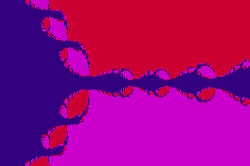

In [ ]:
# Let's test this on the polynomial z = x^3 - x^2 + x + 39 from -5-5j to 10+5j
coeffs = [1, -1, 1, 39]
complex_NM(coeffs, [-5, -5], [10, 5], 250, steps=200)

In [ ]:
# Thats great, but let's step it up a notch
# WARNING: very long run-time
coeffs = [1, -2, 1, 4, -5, 7]
complex_NM(coeffs, [-3, -3], [3, 3], 1000, steps=100)

1000 1000
[-1.55299029+0.j          1.45422959+1.07056853j  1.45422959-1.07056853j
  0.32226556+1.13066849j  0.32226556-1.13066849j]
0  10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  210  220  230  240  250  260  270  280  290  300  310  320  330  340  350  360  370  380  390  400  410  420  430  440  450  460  470  480  490  500  510  520  530  540  550  560  570  

While this image is very pretty, its resolution is still lacking.

I had my computer run overnight to produce an image with 100x the pixels.

Here is the result. Remember to zoom in and let Google Drive finish rendering.

https://drive.google.com/file/d/1i9t1G0wa-3C4JVY8TA3n46o3miMc2JR5/view?usp=sharing

In [ ]:
'''
A function that takes in the coefficients of a polynomial, an x value, and a maximum number of steps,
then applies Newton's Method for the amount of steps or until terminal behaivor is reached
(to n digits of precision), then return the number of steps taken
'''
def poly_newton_steps(poly_coeffs, x, n=15, steps=100):
  x0 = x
  x_list = []
  for i in range(steps):
    x0 -= poly_point(poly_coeffs, x0) / poly_dev(poly_coeffs, x0)  # Newton's Method: x1 = x0 - f(x0) / f'(x0)
    if np.round(x0, n) in x_list:  # If x0 ever becomes what it was before (to 15 digits of precision), then it will begin repeating itself and more calculations are not needed
      return i
    x_list.append(np.round(x0, n))  # Adds each x0 to a list
  return steps  # If all of the steps are completed without a repeat x0 being found, returns last x0

In [ ]:
def complex_NM_steps(poly_coeffs, xy_min, xy_max, x_res, y_res=1, steps=100, n=15):
  # If the vertical resolution is not specified, this gives it a resolution proportional to the horizontal resolution
  if y_res:
    y_res = int(x_res * (xy_max[1] - xy_min[1]) / (xy_max[0] - xy_min[0]))
  print(x_res, y_res)  # Prints what the resolution of the image will be

  # Initializes all real and imaginary parts of x that will be used, according to the resolution and specifed region
  x_reals = np.linspace(xy_min[0], xy_max[0], x_res)
  x_imags = np.linspace(xy_min[1], xy_max[1], y_res)

  # Initializes an array that will contain all complex values of x
  x_values = np.zeros([y_res, x_res], dtype='complex128')

  # Fills in the array with all real and imaginary parts of x
  for j in range(x_res):
    x_values[:, j].real = x_reals[j]
  for i in range(y_res):
    x_values[i, :].imag = x_imags[i]

  # Initializes the image array
  steps_arr = np.zeros([y_res, x_res], dtype='int')

  # Calculates several variables that will be used later
  roots = np.roots(poly_coeffs)
  print(roots)  # Prints the complex roots of the polynomial, which may be useful when looking at the final image

  # Creates the image
  for i in range(y_res):
    if i % 10 == 0:
      print(i, end='  ')
      # Prints the number of completed rows every 10 completed rows
    for j in range(x_res):
      steps_needed = poly_newton_steps(poly_coeffs, x_values[i, j], n, steps)  # Performs Newton's Method on every pixel
      steps_arr[i, j] =  steps_needed

  return [x_values, steps_arr]

500 500
[-1.55299029+0.j          1.45422959+1.07056853j  1.45422959-1.07056853j
  0.32226556+1.13066849j  0.32226556-1.13066849j]
0  10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  210  220  230  240  250  260  270  280  290  300  310  320  330  340  350  360  370  380  390  400  410  420  430  440  450  460  470  480  490  

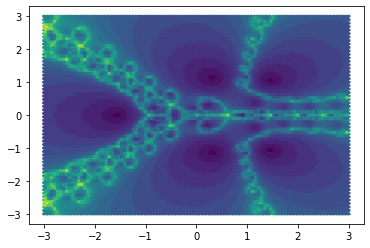

In [ ]:
coeffs = [1, -2, 1, 4, -5, 7]
[complex_x_values, steps_arr] = complex_NM_steps(coeffs, [-3, -3], [3, 3], 1000, steps=100)

x_values = np.ndarray.flatten(complex_x_values.real)
y_values = np.ndarray.flatten(complex_x_values.imag)

steps_arr = np.ndarray.flatten(steps_arr)


plt.hexbin(x_values, y_values, C=steps_arr, cmap='inferno')